# Lab 11: K-Means & DBSCAN
National University of Sciences and Technology — SEECS

# Muhammad Haadhee Sheeraz Mian 
# 478359

- Course: CS 245 Machine Learning (Fall 2025)
- Instructor: Mr. Usama Athar
- Lab Engineer: Ms. Iram Tariq Bhatti

This notebook implements the full lab: theory highlights, DBSCAN foundations and implementation, K-Means clustering (manual and scikit-learn), and a Mini Challenge using the World Happiness Report dataset.

## Objectives
- Understand the working principles of K-Means and DBSCAN.
- Implement both algorithms using Python.
- Learn the basics of K-Means for unsupervised learning.
- Cluster datasets and visualize results effectively.
- Interpret clustering results in real-world applications.

In [14]:
# Imports (pandas, numpy, matplotlib, seaborn, sklearn, plotly)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.datasets import make_moons, make_blobs, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import plotly.express as px

# Plot style
sns.set(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (7,5)

## Core Ideas
- Clustering groups similar data points.
- DBSCAN: density-based clustering; discovers arbitrary shapes; auto-detects number of clusters; flags noise.
- K-Means: partitions into k clusters by minimizing intra-cluster variance (centroid-based).

## Foundations of DBSCAN
Key concepts:
- **Core point**: has ≥ `min_samples` points within radius `eps`.
- **Border point**: within `eps` of a core point but has < `min_samples` neighbors.
- **Noise**: neither core nor border.
- **Neighborhood**: points within `eps`.

Parameter intuition:
- `eps`: neighborhood radius.
- `min_samples`: minimum points to form dense region (common heuristic: ~dimensionality + 1).

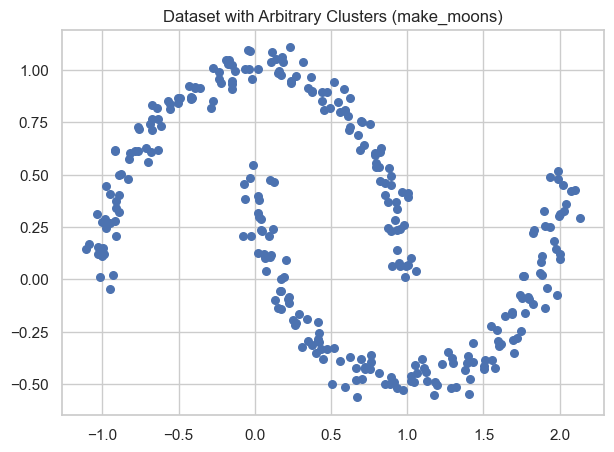

In [15]:
# Learning Intuition dataset: make_moons
X_moons, _ = make_moons(n_samples=300, noise=0.05, random_state=42)
plt.scatter(X_moons[:, 0], X_moons[:, 1], s=30)
plt.title('Dataset with Arbitrary Clusters (make_moons)')
plt.show()

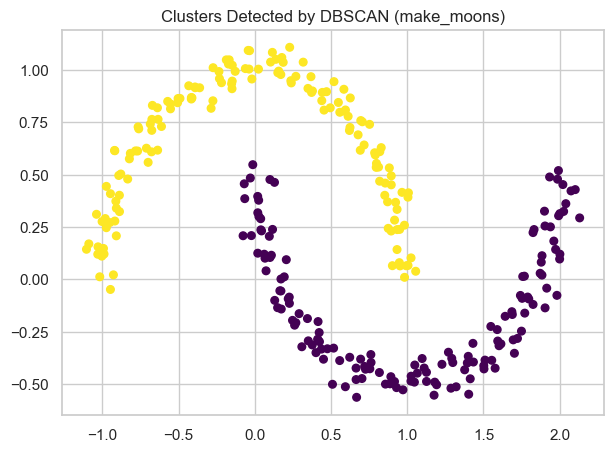

In [16]:
# Apply DBSCAN to make_moons
dbscan_moons = DBSCAN(eps=0.2, min_samples=5)
y_pred_moons = dbscan_moons.fit_predict(X_moons)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_pred_moons, cmap='viridis', s=30)
plt.title('Clusters Detected by DBSCAN (make_moons)')
plt.show()

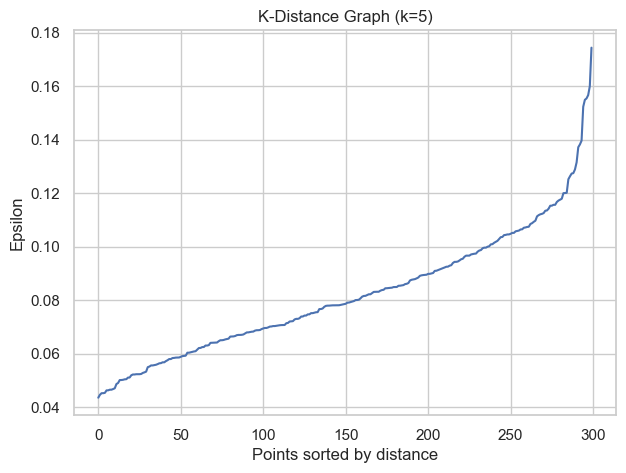

In [17]:
# K-Distance graph to help choose eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_moons)
distances, indices = neighbors_fit.kneighbors(X_moons)
distances_sorted = np.sort(distances[:, -1])
plt.plot(distances_sorted)
plt.title('K-Distance Graph (k=5)')
plt.xlabel('Points sorted by distance')
plt.ylabel('Epsilon')
plt.show()

## Implementation of DBSCAN (Iris example)
We scale features, apply DBSCAN, and visualize clusters on first two scaled features.

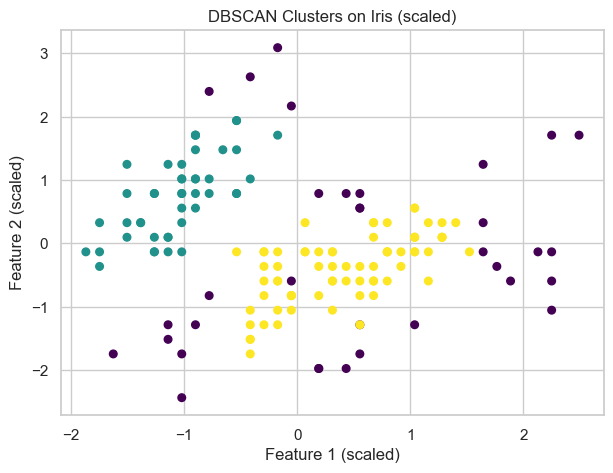

Unique cluster labels: {np.int64(0), np.int64(1), np.int64(-1)}


In [18]:
iris = load_iris()
X_iris = iris.data
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)
dbscan_iris = DBSCAN(eps=0.5, min_samples=5)
y_iris_pred = dbscan_iris.fit_predict(X_iris_scaled)
plt.scatter(X_iris_scaled[:, 0], X_iris_scaled[:, 1], c=y_iris_pred, cmap='viridis', s=30)
plt.title('DBSCAN Clusters on Iris (scaled)')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.show()
unique_labels = set(y_iris_pred)
print(f'Unique cluster labels: {unique_labels}')

## K-Means Clustering (theory recap)
Algorithm steps: choose k, initialize centroids, assign points, update centroids, repeat until convergence.

We show manual implementation followed by scikit-learn implementation.

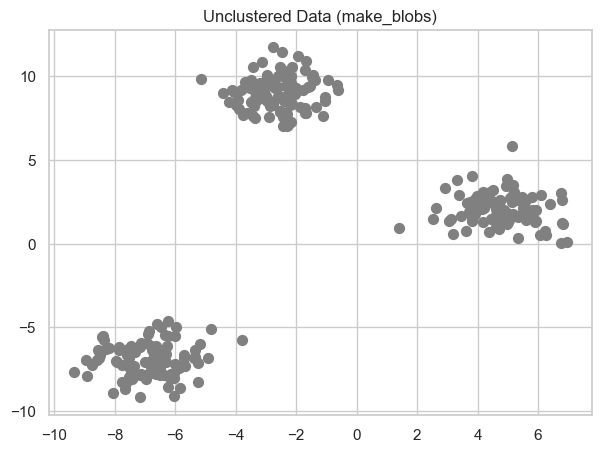

In [19]:
# Generate synthetic data with 3 clusters
data_blobs, _ = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)
plt.scatter(data_blobs[:, 0], data_blobs[:, 1], s=50, color='gray')
plt.title('Unclustered Data (make_blobs)')
plt.show()

Initial Centroids:
 [[ 4.05051408  2.82277178]
 [-6.75933156 -6.36567076]
 [ 4.9208707   1.35047016]]
Converged at iteration 2


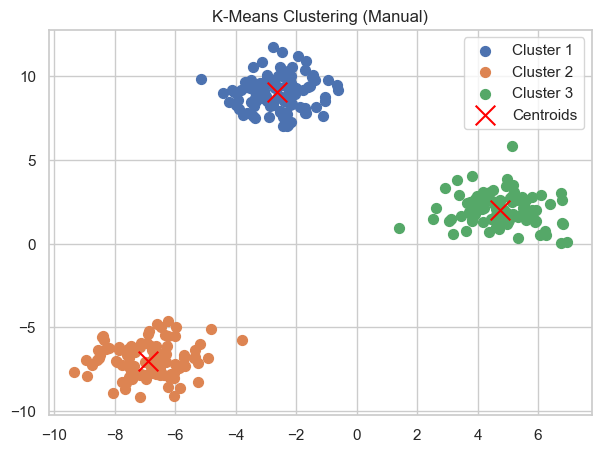

In [20]:
# Manual K-Means implementation
k = 3
max_iterations = 100
np.random.seed(42)
centroids = data_blobs[np.random.choice(data_blobs.shape[0], k, replace=False)]
print('Initial Centroids:\n', centroids)

def assign_clusters(data, centroids):
    distances = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

def update_centroids(data, labels, k):
    return np.array([data[labels == i].mean(axis=0) for i in range(k)])

for iteration in range(max_iterations):
    labels_manual = assign_clusters(data_blobs, centroids)
    new_centroids = update_centroids(data_blobs, labels_manual, k)
    if np.allclose(centroids, new_centroids):
        print(f'Converged at iteration {iteration}')
        break
    centroids = new_centroids

# Plot result
for i in range(k):
    plt.scatter(data_blobs[labels_manual == i][:, 0], data_blobs[labels_manual == i][:, 1], s=50, label=f'Cluster {i+1}')
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='x', label='Centroids')
plt.title('K-Means Clustering (Manual)')
plt.legend()
plt.show()

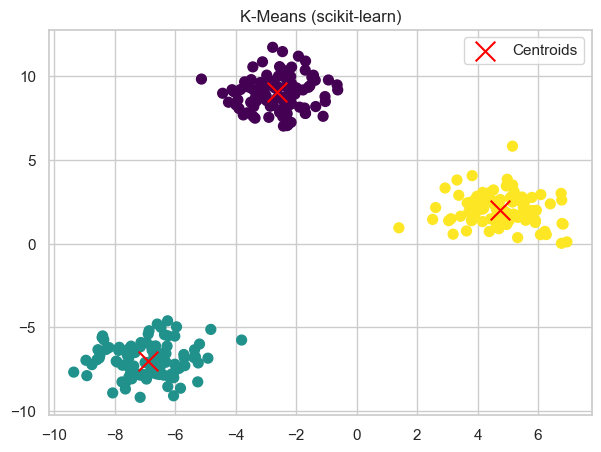

In [21]:
# K-Means with scikit-learn
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
labels_sklearn = kmeans.fit_predict(data_blobs)
plt.scatter(data_blobs[:, 0], data_blobs[:, 1], c=labels_sklearn, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='x', label='Centroids')
plt.title('K-Means (scikit-learn)')
plt.legend()
plt.show()

## Elbow Method (WCSS)
We compute within-cluster sum of squares (inertia) for k=1..10 and visualize the elbow.

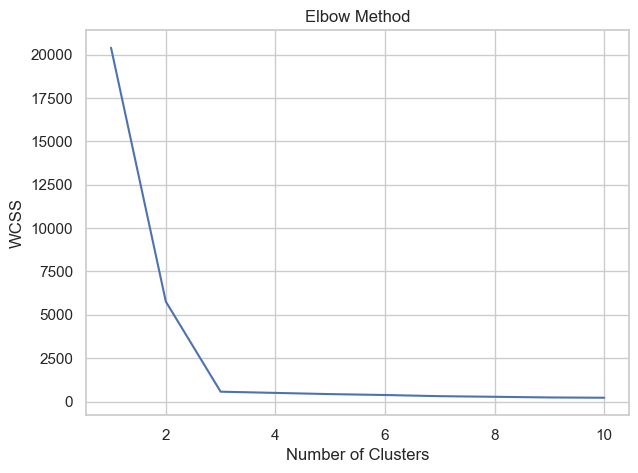

In [22]:
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    km.fit(data_blobs)
    wcss.append(km.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

## Mini Challenge: World Happiness Report
We cluster countries based on socio-economic indicators using K-Means and DBSCAN.

Dataset: 2016 World Happiness Report (public CSV).

In [23]:
# Load World Happiness Report (2016) from local file
happiness = pd.read_csv('archive (16)/2016.csv')
happiness.head()

,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596


In [24]:
# Select relevant features and preprocess
cols = ['Region', 'Happiness Rank', 'Happiness Score', 'Economy (GDP per Capita)',
         'Health (Life Expectancy)', 'Freedom', 'Generosity', 'Trust (Government Corruption)']
df = happiness[cols].dropna().copy()
features = df[[
    'Happiness Score', 'Economy (GDP per Capita)', 'Health (Life Expectancy)',
    'Freedom', 'Generosity', 'Trust (Government Corruption)'
]]
scaler = StandardScaler()
X = scaler.fit_transform(features)

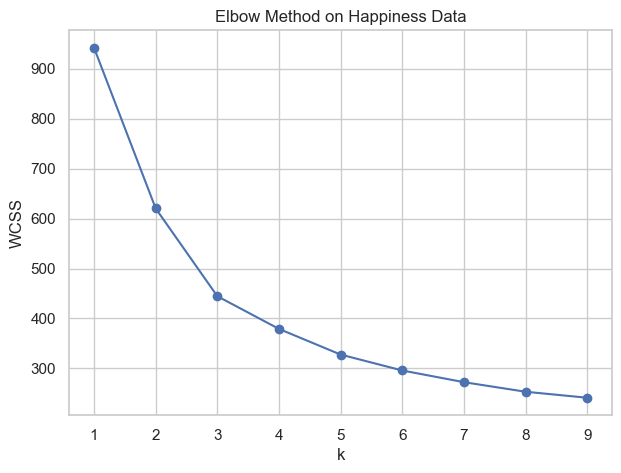

In [25]:
# Determine optimal k via Elbow on this dataset
wcss_h = []
Ks = range(1, 10)
for i in Ks:
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    km.fit(X)
    wcss_h.append(km.inertia_)
plt.plot(Ks, wcss_h, marker='o')
plt.title('Elbow Method on Happiness Data')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.show()

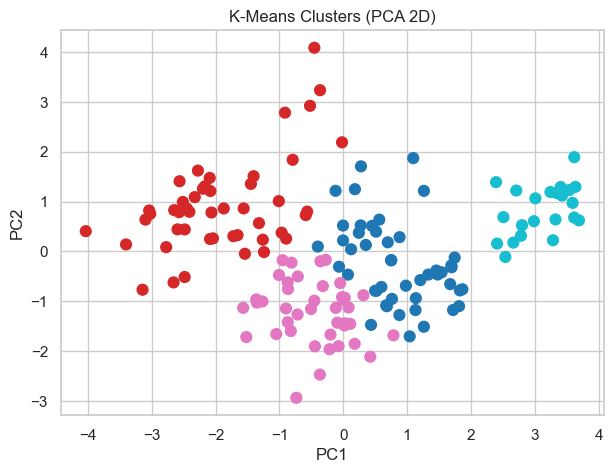

In [26]:
# K-Means clustering (choose k=4 as a reasonable default; adjust per elbow)
k_opt = 4
kmeans_h = KMeans(n_clusters=k_opt, init='k-means++', n_init=10, random_state=42)
labels_h = kmeans_h.fit_predict(X)
pca2 = PCA(n_components=2, random_state=42)
X2 = pca2.fit_transform(X)
plt.scatter(X2[:,0], X2[:,1], c=labels_h, cmap='tab10', s=60)
plt.title('K-Means Clusters (PCA 2D)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

In [27]:
# Analyze clusters: mean feature values per cluster
df_clusters = df.copy()
df_clusters['Cluster'] = labels_h
cluster_profile = df_clusters.groupby('Cluster')[features.columns].mean()
cluster_profile

,Happiness Score,Economy (GDP per Capita),Health (Life Expectancy),Freedom,Generosity,Trust (Government Corruption)
Cluster,,,,,,
0,6.011149,1.131011,0.656278,0.449963,0.241377,0.116592
1,4.157000,0.442289,0.276056,0.310421,0.271804,0.122913
2,5.187561,1.048680,0.624436,0.254681,0.135474,0.077550
3,7.018636,1.491734,0.823847,0.548458,0.382715,0.325938


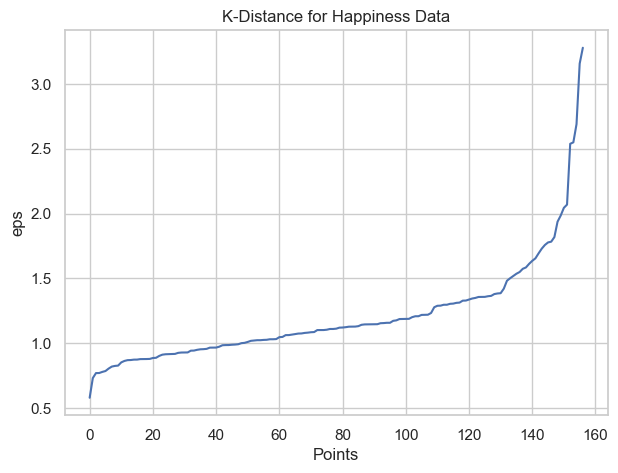

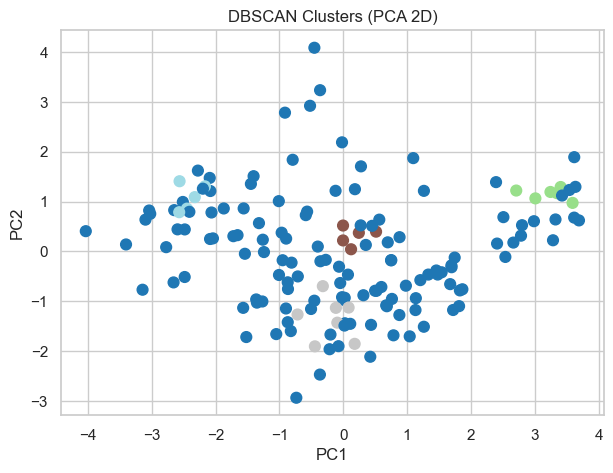

DBSCAN unique labels: [-1  0  1  2  3]


In [28]:
# DBSCAN on the same dataset (tune eps/min_samples)
neighbors = NearestNeighbors(n_neighbors=5).fit(X)
dists = np.sort(neighbors.kneighbors(X)[0][:, -1])
plt.plot(dists)
plt.title('K-Distance for Happiness Data')
plt.xlabel('Points')
plt.ylabel('eps')
plt.show()

dbscan_h = DBSCAN(eps=0.8, min_samples=5)  # adjust eps after inspecting k-distance graph
labels_db = dbscan_h.fit_predict(X)
plt.scatter(X2[:,0], X2[:,1], c=labels_db, cmap='tab20', s=60)
plt.title('DBSCAN Clusters (PCA 2D)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()
print('DBSCAN unique labels:', np.unique(labels_db))

### Plotly visualization (interactive)
A bubble scatter of PCA components, colored by K-Means cluster, sized by Happiness Score.

In [29]:
plot_df = pd.DataFrame(X2, columns=['PC1','PC2'])
plot_df['Cluster'] = labels_h.astype(str)
plot_df['Country'] = happiness['Country'].values[:len(df)]
plot_df['Region'] = df['Region'].values
plot_df['Happiness Score'] = df['Happiness Score'].values
fig = px.scatter(plot_df, x='PC1', y='PC2', color='Cluster', size='Happiness Score', 
                 hover_data=['Region','Country'], title='World Happiness Clusters (K-Means, PCA)')
fig.show()

## Bonus: Regression on Happiness Score
Use cluster labels and socio-economic features to predict Happiness Score. Evaluate with R² and MAE.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

X_reg = np.concatenate([X, labels_h.reshape(-1,1)], axis=1)
y_reg = df['Happiness Score'].values
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('R²:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

R²: 1.0
MAE: 4.163336342344337e-16
